# Make figures for supplementary figure 3

## Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border

import pyclesperanto_prototype as cle

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
cle.select_device('GTX')

<NVIDIA GeForce GTX TITAN X on Platform: NVIDIA CUDA (1 refs)>

## Functions

In [1]:
def segment(data_name, suffix, sigma_spot_detection = 8, sigma_outline = 2):
    res = []
    for s in suffix:
        print(s)
        img = np.load(f'../result/{data_name}{s}.npy')
        img = img[25:75, 10:630, 45:img.shape[2]-50]
        img_gpu = cle.push(img)
        segmented = cle.voronoi_otsu_labeling(img_gpu, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)
        res.append(cle.pull(segmented))

    return res

In [2]:
def calculate_props(data_name, suffix, segmented, scale=(None, None, None)):
    res = []
    surface = []
    
    for i, s_data in enumerate(segmented):
        print(suffix[i])
        s_data = clear_border(s_data)
        s_data = remove_small_objects(s_data, min_size=100)
        intensity_img = np.load(f'../result/{data_name}{suffix[i]}.npy')
        intensity_img = intensity_img[25:75, 10:630, 45:intensity_img.shape[2]-50]
        props = pd.DataFrame(regionprops_table(label_image=s_data, intensity_image=intensity_img,
                                               properties=('label', 'intensity_mean', 'area', 'solidity', 'bbox'), spacing=scale))
        props = props.rename(columns={'label':'Label', 'intensity_mean':'Mean intensity', 'area': 'Volume', 'solidity': 'Solidity'})
        res.append(props)

    res = pd.concat(res)
    res = res.reset_index(drop=True)
        
    return res

## Analysis

In [5]:
data = 'id551_MDCK_unit_on_on_01_300Hz_405_250mW_488_150mW_488'
suffix = ['_X3']
#suffix = ['', '_X1', '_X2', '_X3', '_X4', '_X5']

In [6]:
res_segment = segment(data, suffix)

_X3
size: 50


In [7]:
scale = np.repeat(0.295*4, 3)

In [8]:
res_props = calculate_props(data, suffix, res_segment, scale=scale)

_X3


In [9]:
res_props

,Label,Mean intensity,Volume,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,5,653.704529,28762.918192,0.839375,8,426,13,45,459,45
1,6,635.411682,62162.472688,0.800669,6,387,2,48,428,54
2,8,706.691467,32885.285480,0.553910,11,555,21,46,612,63
3,9,613.745667,24780.208624,0.853827,11,82,43,45,118,73
4,10,742.037537,30796.991808,0.896756,13,524,43,46,561,78
...,...,...,...,...,...,...,...,...,...,...
289,376,580.044922,38188.992776,0.850426,4,66,2612,47,101,2649
290,377,656.918640,32423.593488,0.837393,9,261,2612,45,293,2651
291,378,1000.335571,3701.751096,0.849227,18,112,2646,35,130,2663
292,379,677.359985,33230.322200,0.685314,13,326,2640,46,369,2690


In [10]:
print(res_props['Volume'].min(), res_props['Volume'].max())
print(res_props['Solidity'].min(), res_props['Solidity'].max())

172.51835999999997 91640.10979999999
0.42904274177663976 0.978835978835979


In [11]:
volume_thresh = 20000
solidity_thresh = 0.8

In [12]:
res_props['Selection'] = np.where((res_props['Volume']>volume_thresh) & (res_props['Solidity']>solidity_thresh), 'Retained', 'Removed')

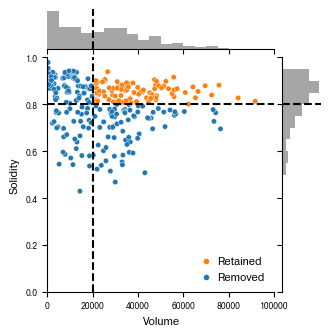

In [38]:
g = sns.jointplot(data=res_props, x='Volume', y='Solidity',
                  height=3.5, hue='Selection', palette=['tab:orange', 'tab:blue'],
                  xlim=(0, 100000), ylim=(0.0, 1.0), joint_kws={'s': 15})
g.ax_marg_x.cla()
g.ax_marg_y.cla()
g.ax_marg_x.hist(res_props['Volume'], bins=20, range=(0, 100000), color='grey', alpha=0.7)
g.ax_marg_x.get_yaxis().set_visible(False)
g.ax_marg_x.tick_params(labelbottom=False)
g.ax_marg_y.hist(res_props['Solidity'], bins=20, range=(0, 1), color='grey', orientation='horizontal', alpha=0.7)
g.ax_marg_y.get_xaxis().set_visible(False)
g.ax_marg_y.tick_params(labelleft=False)
g.refline(x=20000, y=0.8, color='black')


g.ax_joint.tick_params(axis = 'x', labelsize=6)
g.ax_joint.tick_params(axis = 'y', labelsize=6)
g.ax_joint.set_xlabel('Volume', fontsize=8)
g.ax_joint.set_ylabel('Solidity', fontsize=8)
g.ax_joint.legend(fontsize=8, markerscale=0.5, handletextpad=0, frameon=False)

plt.savefig('../result/spheroid_volume_solidity.pdf', bbox_inches='tight', pad_inches=0.05)

In [67]:
res_props['Filter'] = np.where((res_props['Volume']>volume_thresh) & (res_props['Solidity']>solidity_thresh), 'Retained', 'Removed')

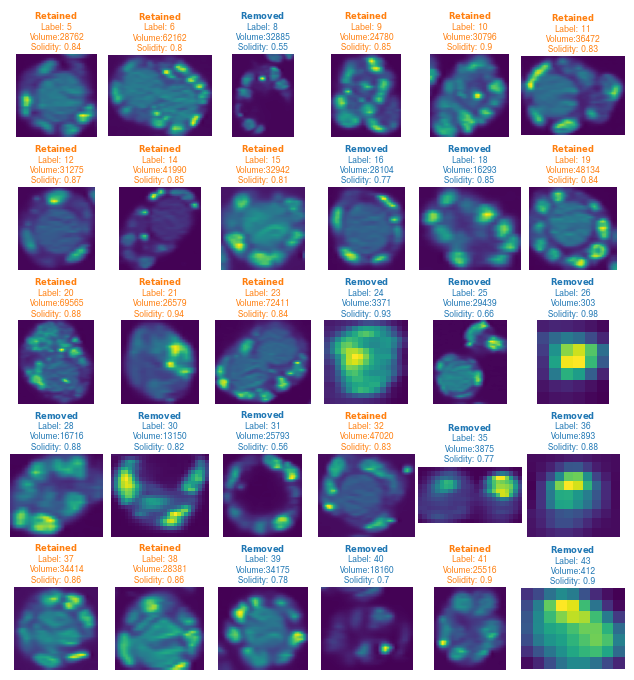

In [68]:
img = np.load(f'../result/{data}{suffix[0]}.npy')
img = img[25:75, 10:630, 45:img.shape[2]-50]

n = 30

fig, axes = plt.subplots(5, 6, figsize=(8, 8))
axes = axes.flatten()
for i in range(n):
    axes[i].imshow(img[25, int(res_props.iloc[i, :]['bbox-1']):int(res_props.iloc[i, :]['bbox-4']), int(res_props.iloc[i, :]['bbox-2']):int(res_props.iloc[i, :]['bbox-5'])])
    axes[i].axis('off')
    if res_props.iloc[i, :]['Filter']=='Retained':
        axes[i].set_title(r'$\bf{'+ res_props.iloc[i, :]['Filter'] +'}$'+'\nLabel: '+str(int(res_props.iloc[i, :]['Label']))+'\nVolume:'+str(int(res_props.iloc[i, :]['Volume']))+'\nSolidity: '+str(np.round(res_props.iloc[i, :]['Solidity'], 2)), size=6, y=0.95, color='tab:orange')
    else:
        axes[i].set_title(r'$\bf{'+ res_props.iloc[i, :]['Filter'] +'}$'+'\nLabel: '+str(int(res_props.iloc[i, :]['Label']))+'\nVolume:'+str(int(res_props.iloc[i, :]['Volume']))+'\nSolidity: '+str(np.round(res_props.iloc[i, :]['Solidity'], 2)), size=6, y=0.95, color='tab:blue')
plt.subplots_adjust(wspace=0, hspace=0.6)

plt.savefig('../result/spheroid_tile.pdf', bbox_inches='tight', pad_inches=0.05)